# Downstream analysis
We create a vcf file containing small and structral variants annotated with their AF and predicted functional impact. Here we are going to go through how to explore those variants.

Let's start by visualizing structral variants to make sure that the callers did a good job.


I am going to


In [14]:
%%bash 
grep "cuteSV-25-8240662-DEL-0-1405" results/cuteSV/ERR5043144.hifi.pbmm2.phased.vcf

25	8240662	cuteSV-25-8240662-DEL-0-1405	AATGTCTGATTTTATTCTTTGGAAAGAATGATGCTAAAGCTGAAACTCCAGTACTTTGGCCACCTCATGTGAAGAGTTGACTCATTGGAAAAGACTCTGATGCTGGGAGGGATTGGGGGCAGGAGGAGAAGGGGATTACAGAGGATGAGATGGCTGGATGGCATCACCAACTCAATGGACATGGGTTTGGGTGGACTCCGGGAGTTGGTGATGGACAGGGAGGCCTGGCGTGCTGTGGTTCATGGGGTCAGGAAGAGTCAGACACAACTGAGCGACTGAACTGAACTGATTATGAATATGTCAAGTCCTTATTGCAAGAATTCCAGATAAGAAATATTGCCCTCATTTCAGATAGGAGGAAACTGAGGAAACTTCCCAAGGGTGATTTCACTGGGGAGCCACTAAACCTGGACTCCTTTCATTTCAACTGCTTTTCATGAGGCACCTGTGTGGTCTACCTGGTTCCATTAACTTCACTGTCTTTCTTATTGAGAGCCTGCCTTCCTAAGCAGAAAAATCAAGGAGGGAAATTAAAAGCACTTGTGAAGTCATTTTACCCATCACTGACTGCTGGGCGCTCCCTAAATAGAAGGATCTCGTATGTGTTTGCAAATGCTAATCCACTCTGGAGTCTTTCATTTTTAGAAAAAAGGGGTGCTGGGATCCATGAGCACTGAGATTCGGCTTCACTGTCATGTTCCTAAGCACACAGAAATCACACGTCTTTAGCTCTTTTGGTCTTCCTGGCCCTGCATGCAAAGGAGTTTGAAAACCTTCCAGAAGCTGCCACGTGCCATGATCAGCAGGAAGCTTTAGATTCTATGCAAGAACAGAAAATCAAGAGGCTTACACCGGCATGGTGAGTGAGGCTTTGTGGTCTTTCAGCAAGACTGTTTTCATATATATTTATAAAGTGCCCACTATACGCTGGGTACTGAGAATATAGAAATGATAACACCT

# Samplot
The variant of length(1405) starts at 8240662 and ends at 8242067. We are going to use samplot to visualize this variant. 
Plotting using our snakemake workflow is very simple. 

just run "snakemake -j1 -p results/samplot/<SVTYPE>_<chrom>_<start>_<end>.png"

In [12]:
%%bash
snakemake -j1 -p results/samplot/DEL_25_8240662_8242067.png

Detecting duplicate sample names ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00


Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Job stats:
job        count    min threads    max threads
-------  -------  -------------  -------------
samplot        1              1              1
total          1              1              1

Select jobs to execute...

[Sun Jan  8 22:03:18 2023]
rule samplot:
    input: results/mapping/ERR5043144.hifi.pbmm2.phased.bam, results/mapping/ERR7091271.ont.minimap2.phased.bam, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.gff.gz, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.gff.gz.tbi, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.rmsk.bed.gz, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.rmsk.bed.gz.tbi, /home/mshokrof/workshop_12Jan_2023_data/goldstandard/callset_filered.25.bed.gz, /home/mshokrof/workshop_12Jan_2023_data/goldstandar

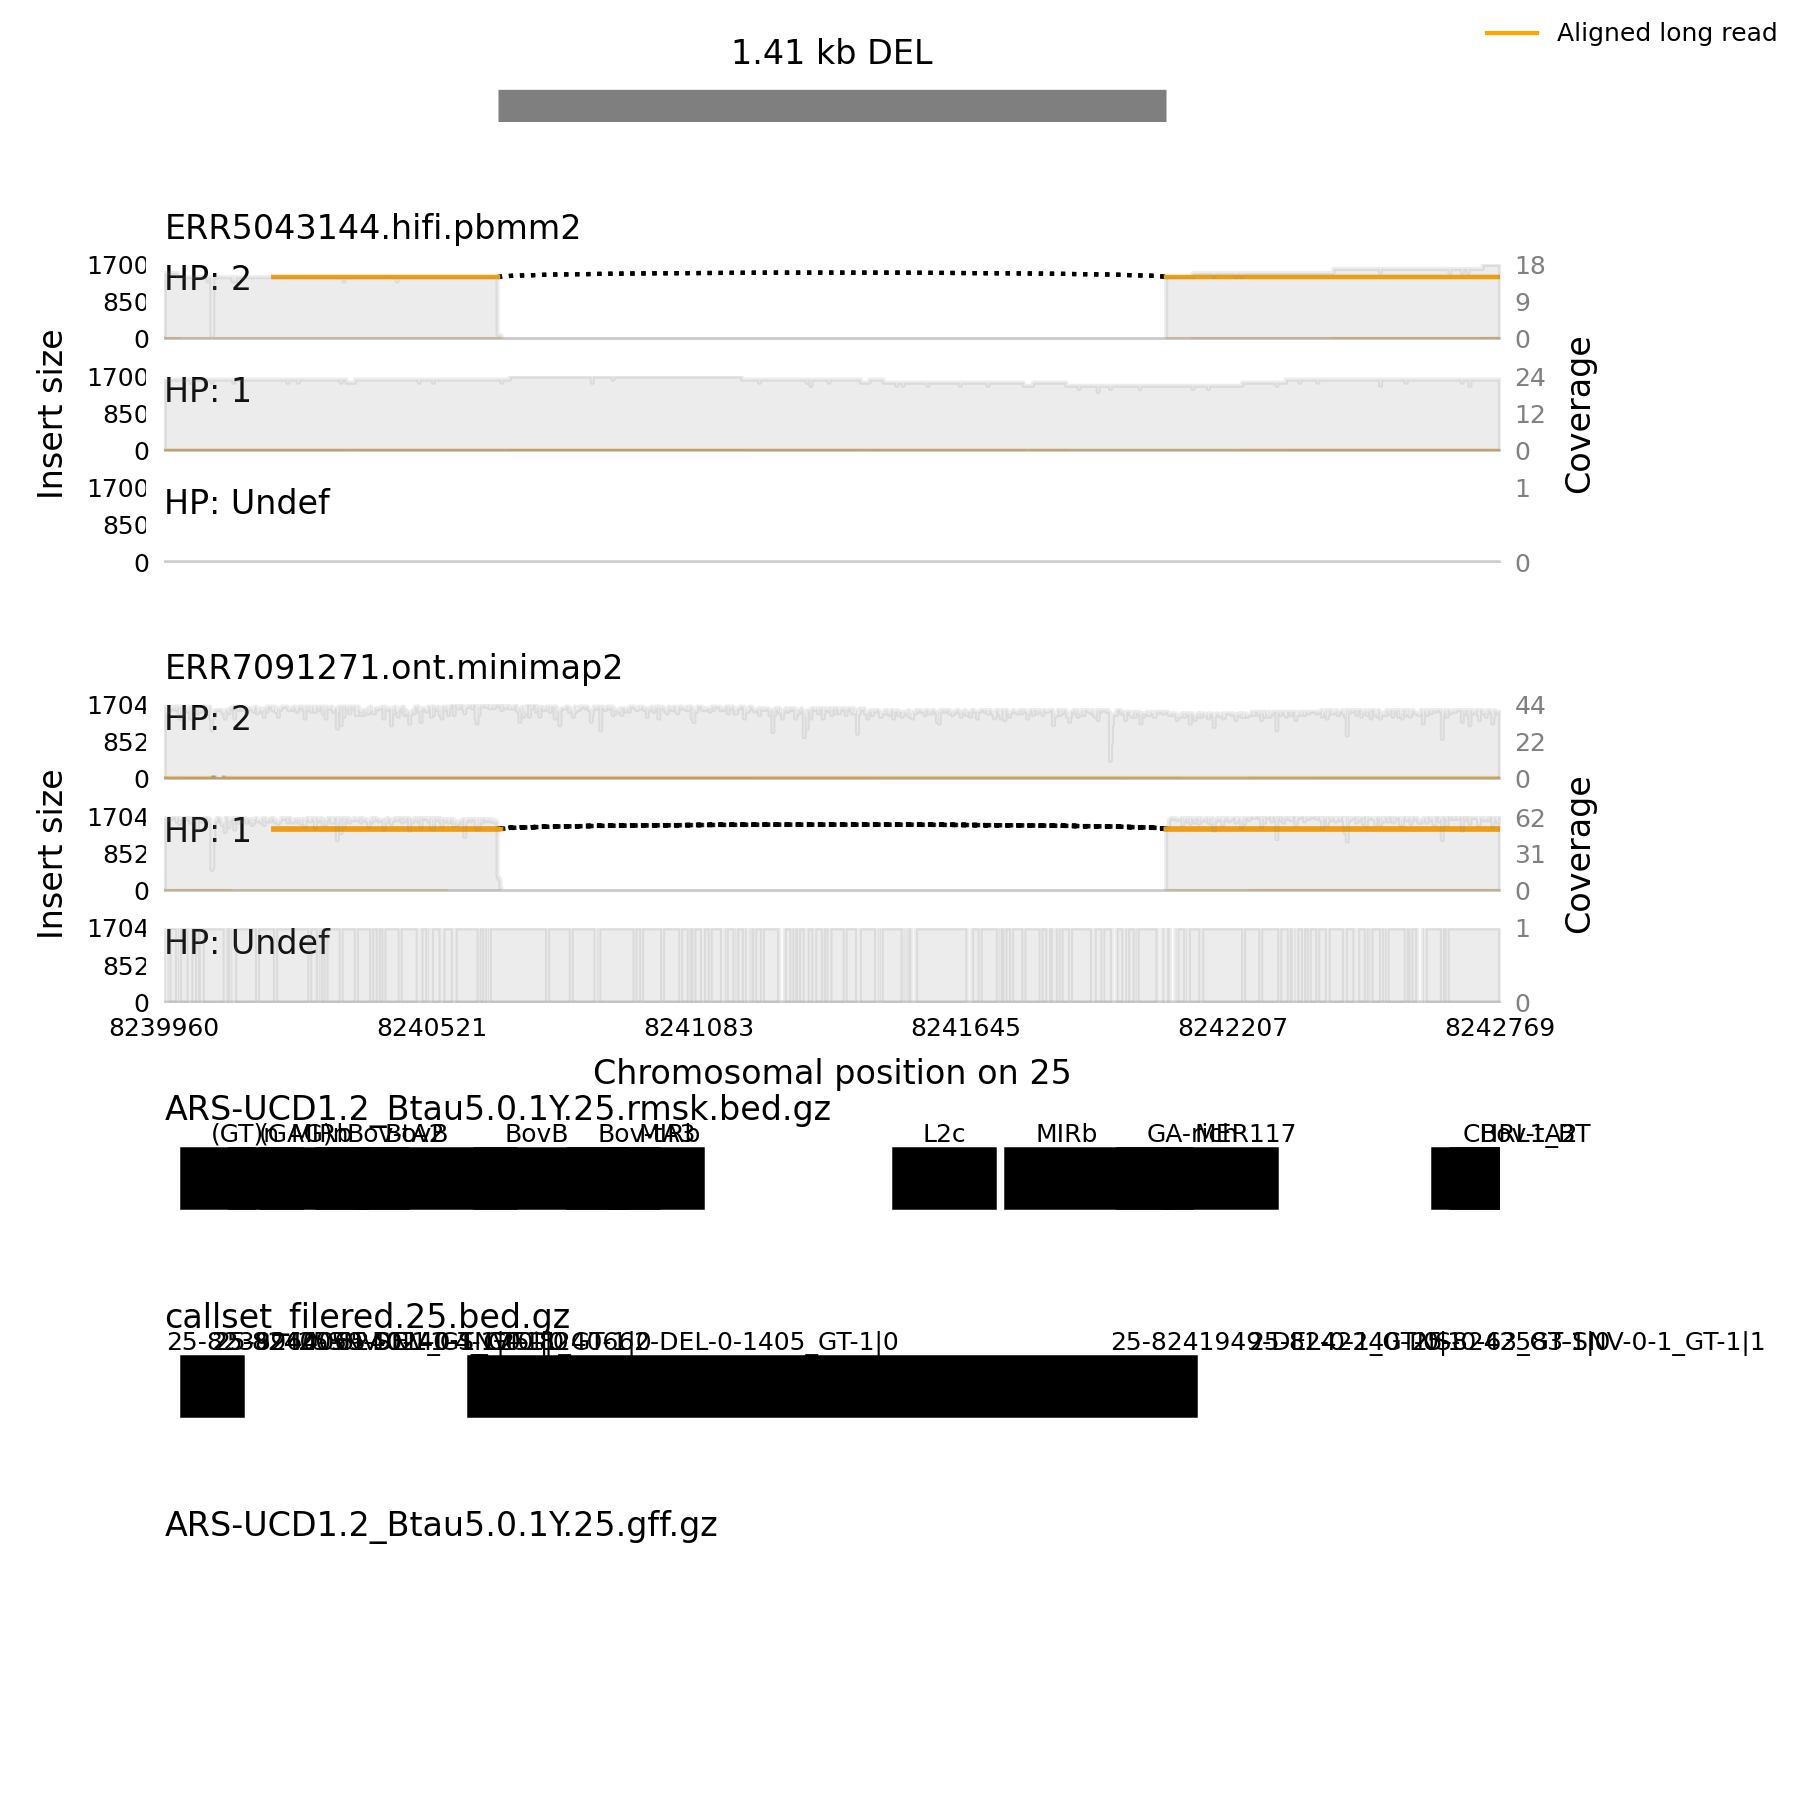

In [13]:
from IPython.display import Image
Image(filename='results/samplot/DEL_25_8240662_8242067.png') 

Benchmarking SV is not an easy job because tools always disagree about the positions of breakpoints. Therefore, we can expect that some SV in our benchmarks tagged as FP while it was correct but the breakpoint wasnt matching.

Let's view a SV called by pbsv but was tagged as FP.


In [15]:
%%bash
grep "pbsv-25-9733349-DEL-0-663" results/pbsv/ERR5043144.hifi.pbmm2.phased.vcf

25	9733349	pbsv-25-9733349-DEL-0-663	TCTTTTTTTTTTTTTTTTTTTAAAGGCTTAAAATGTATTTTAATAAGTTCATGTTGCATTATTCATTTCTCAGAAAAACTTCAAAGGTATTAGGGACAAATCAAACATGGTACACCAATAAAAAATGCACAGCGTAACTACCTAAGATAGGCAAAGCTAAGAGCTACCGTCTGACATTCAGCATACAGCAACCCTGTTCTCAAGATTGTACTAGGCCTATCAAGAAAGCTGTGAATGGCAACATCACAGACACAAAAGGGCCATTTCTGGGTTGTCCTTACCCAAGAAAAAGATGGAGGCAAGTTTAACACAAGATTTTTTTAAAGATACACTAAATGAAAATCTCTAAGAGAAAATGTCTTCCTTGGGACATGAAAGGGTAATATATGGGACATAACAGAACCGTATGTATGTTGTCTGTGACCTCTGTGGACATGTGCCTGAATTCCCACCTGGGAGTGATTGGAACAGTGGGGCCAAGGTCATTGGGGGATGTTTGGTTTTTGTGGTATATGTGGCAGGATCTCTGGGGTGAGACAGTGCACTAAGTCGTGTCCGACTCTTGCGACCCCATGGACTGTAGCCTGCCAGGCTCCTCTGTCTATGGGATTCTCCAGGCAAGAATACTGGAGTGGGTTGCCATTTCCTTCTCCAGAAATCGAGT	T	.	PASS	ID=pbsv-25-9733349-DEL-0-663	GT	0|1


In [16]:
%%bash
snakemake -j1 -p results/samplot/DEL_25_9733349_9734012.png

Detecting duplicate sample names ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00


Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Job stats:
job        count    min threads    max threads
-------  -------  -------------  -------------
samplot        1              1              1
total          1              1              1

Select jobs to execute...

[Sun Jan  8 22:10:52 2023]
rule samplot:
    input: results/mapping/ERR5043144.hifi.pbmm2.phased.bam, results/mapping/ERR7091271.ont.minimap2.phased.bam, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.gff.gz, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.gff.gz.tbi, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.rmsk.bed.gz, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.rmsk.bed.gz.tbi, /home/mshokrof/workshop_12Jan_2023_data/goldstandard/callset_filered.25.bed.gz, /home/mshokrof/workshop_12Jan_2023_data/goldstandar

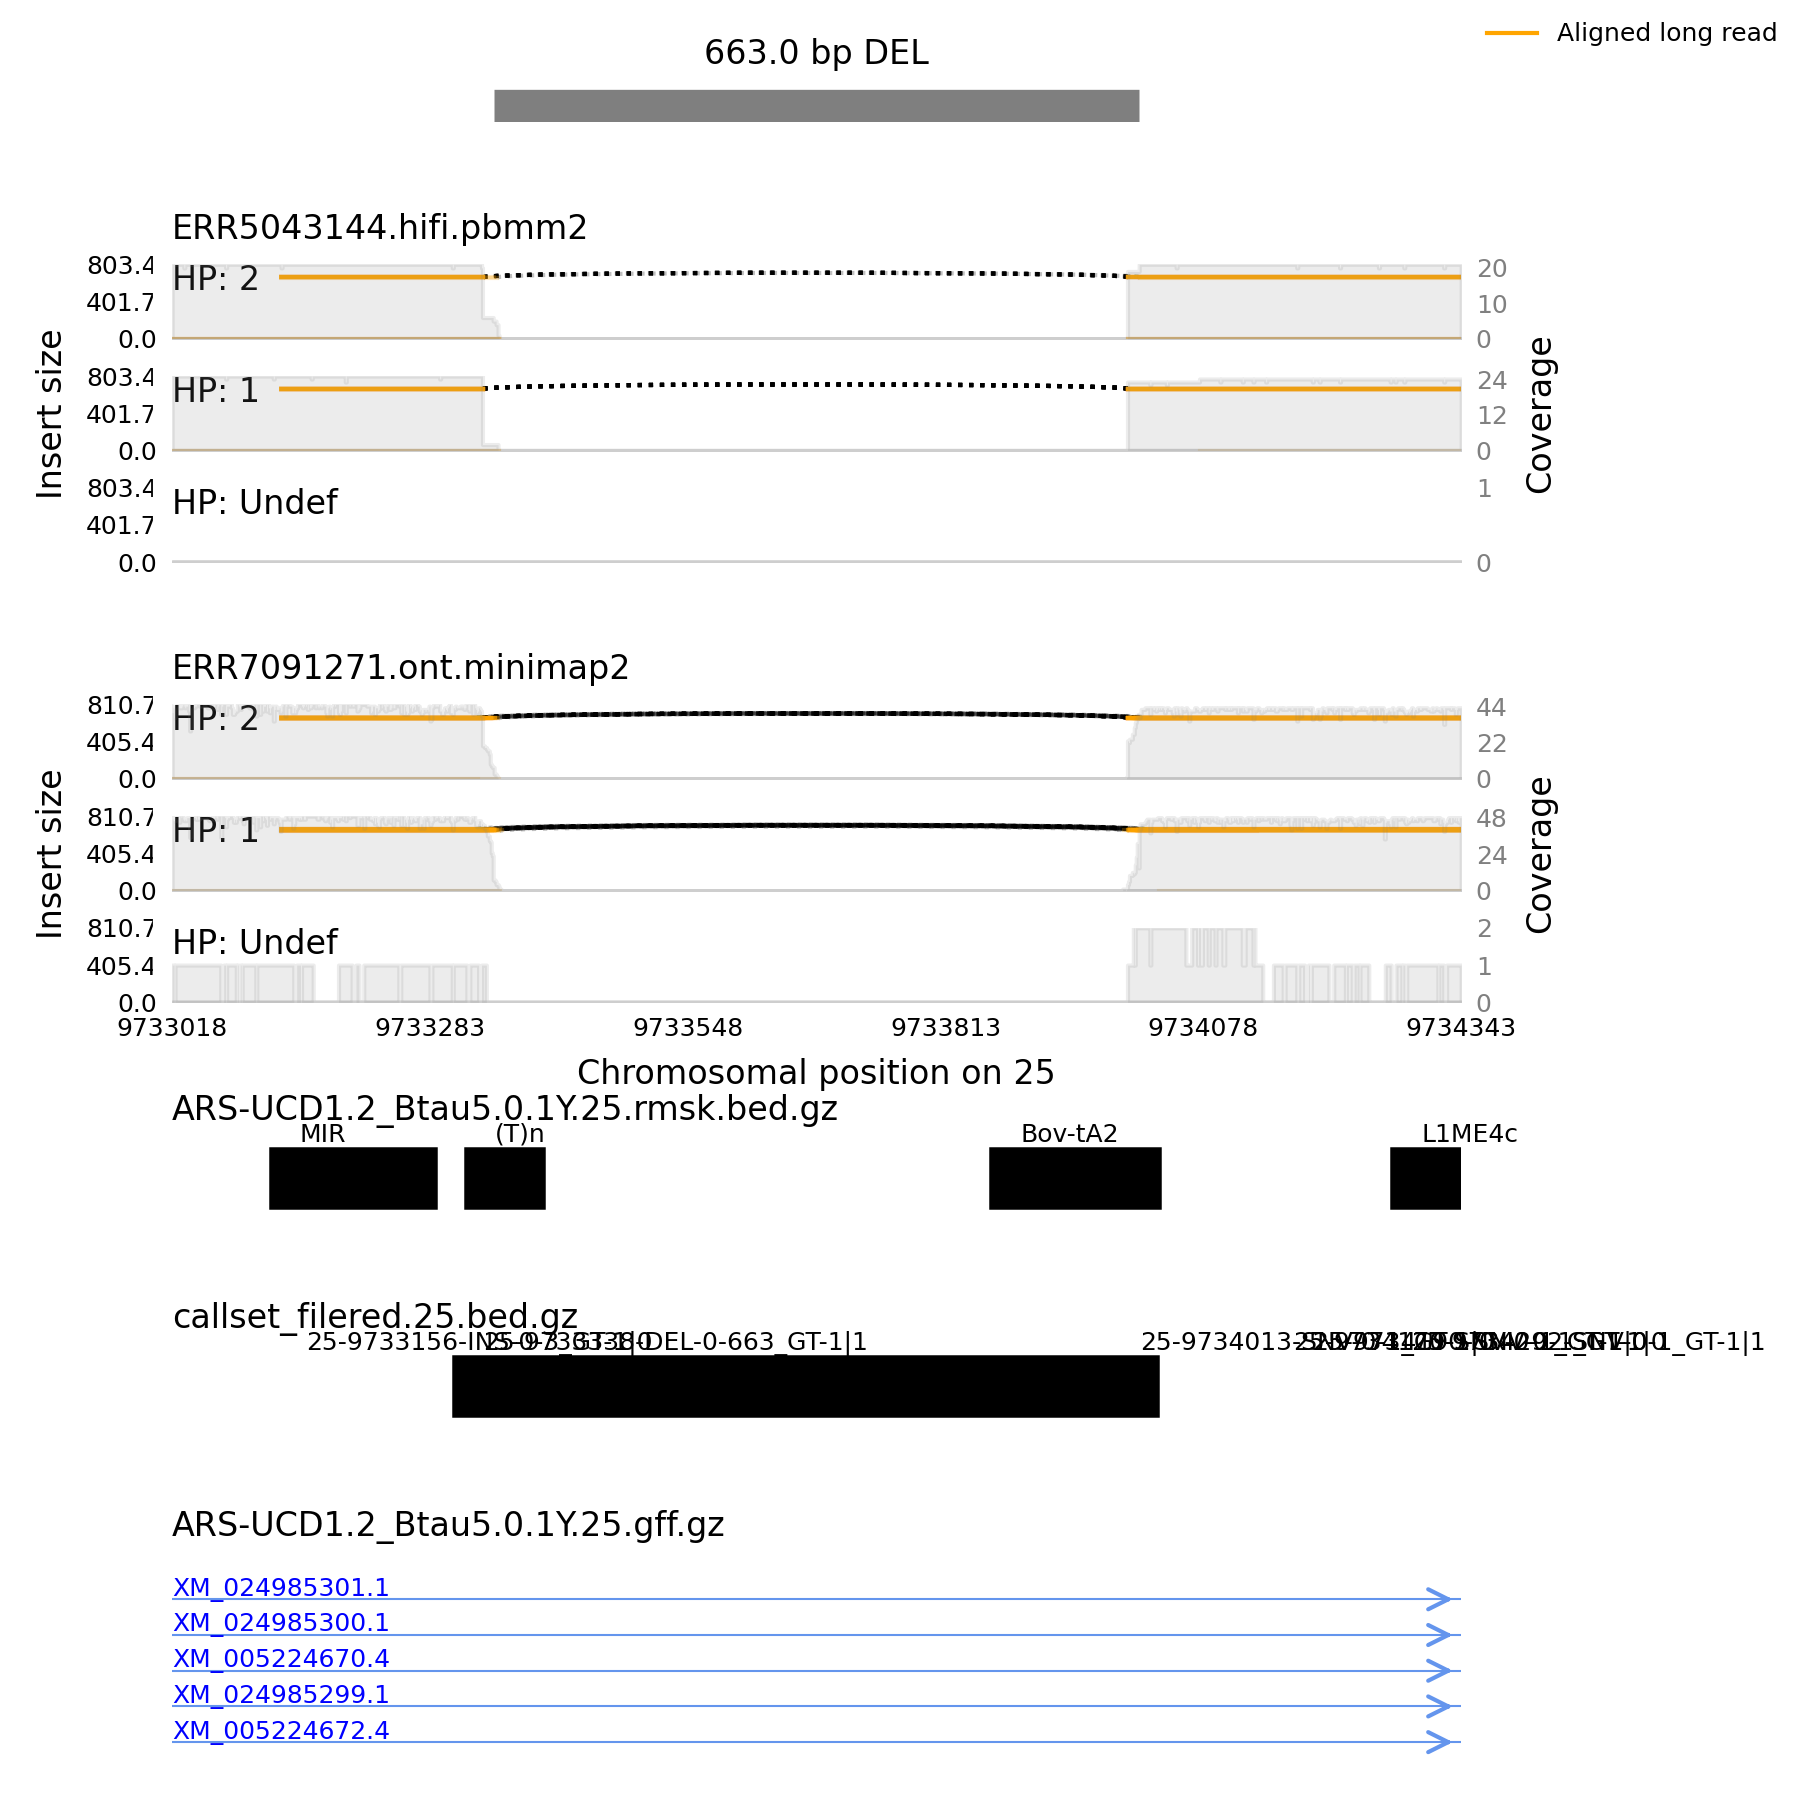

In [17]:
Image(filename='results/samplot/DEL_25_9733349_9734012.png') 

Looks like that SV is actually correct. Lesson here is that You have to visualize SV to make sure that everything is correct.

# Variant Effect predictor
We used VEP to predict the effect of the variants. The following figgure summarizes the annotations produced by VEP. More information is available on their [website](https://uswest.ensembl.org/info/genome/variation/prediction/predicted_data.html)
![VEP](https://uswest.ensembl.org/info/genome/variation/prediction/consequences.jpg)

Lets first, look at the summary results they produced. On the left, Browse "results/variants/annotated/cattle_taurus_10.cuteSV.ERR7091271.ont.minimap2/cattle_taurus_10.cuteSV.ERR7091271.ont.minimap2/" and download the report " merged.stat.html"

In [18]:
%%bash
snakemake -j1 -p results/samplot/DEL_25_2585286_2585682.png

Detecting duplicate sample names ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00


Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Conda environments: ignored
Job stats:
job        count    min threads    max threads
-------  -------  -------------  -------------
samplot        1              1              1
total          1              1              1

Select jobs to execute...

[Sun Jan  8 22:25:28 2023]
rule samplot:
    input: results/mapping/ERR5043144.hifi.pbmm2.phased.bam, results/mapping/ERR7091271.ont.minimap2.phased.bam, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.gff.gz, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.gff.gz.tbi, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.rmsk.bed.gz, /home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.rmsk.bed.gz.tbi, /home/mshokrof/workshop_12Jan_2023_data/goldstandard/callset_filered.25.bed.gz, /home/mshokrof/workshop_12Jan_2023_data/goldstandar

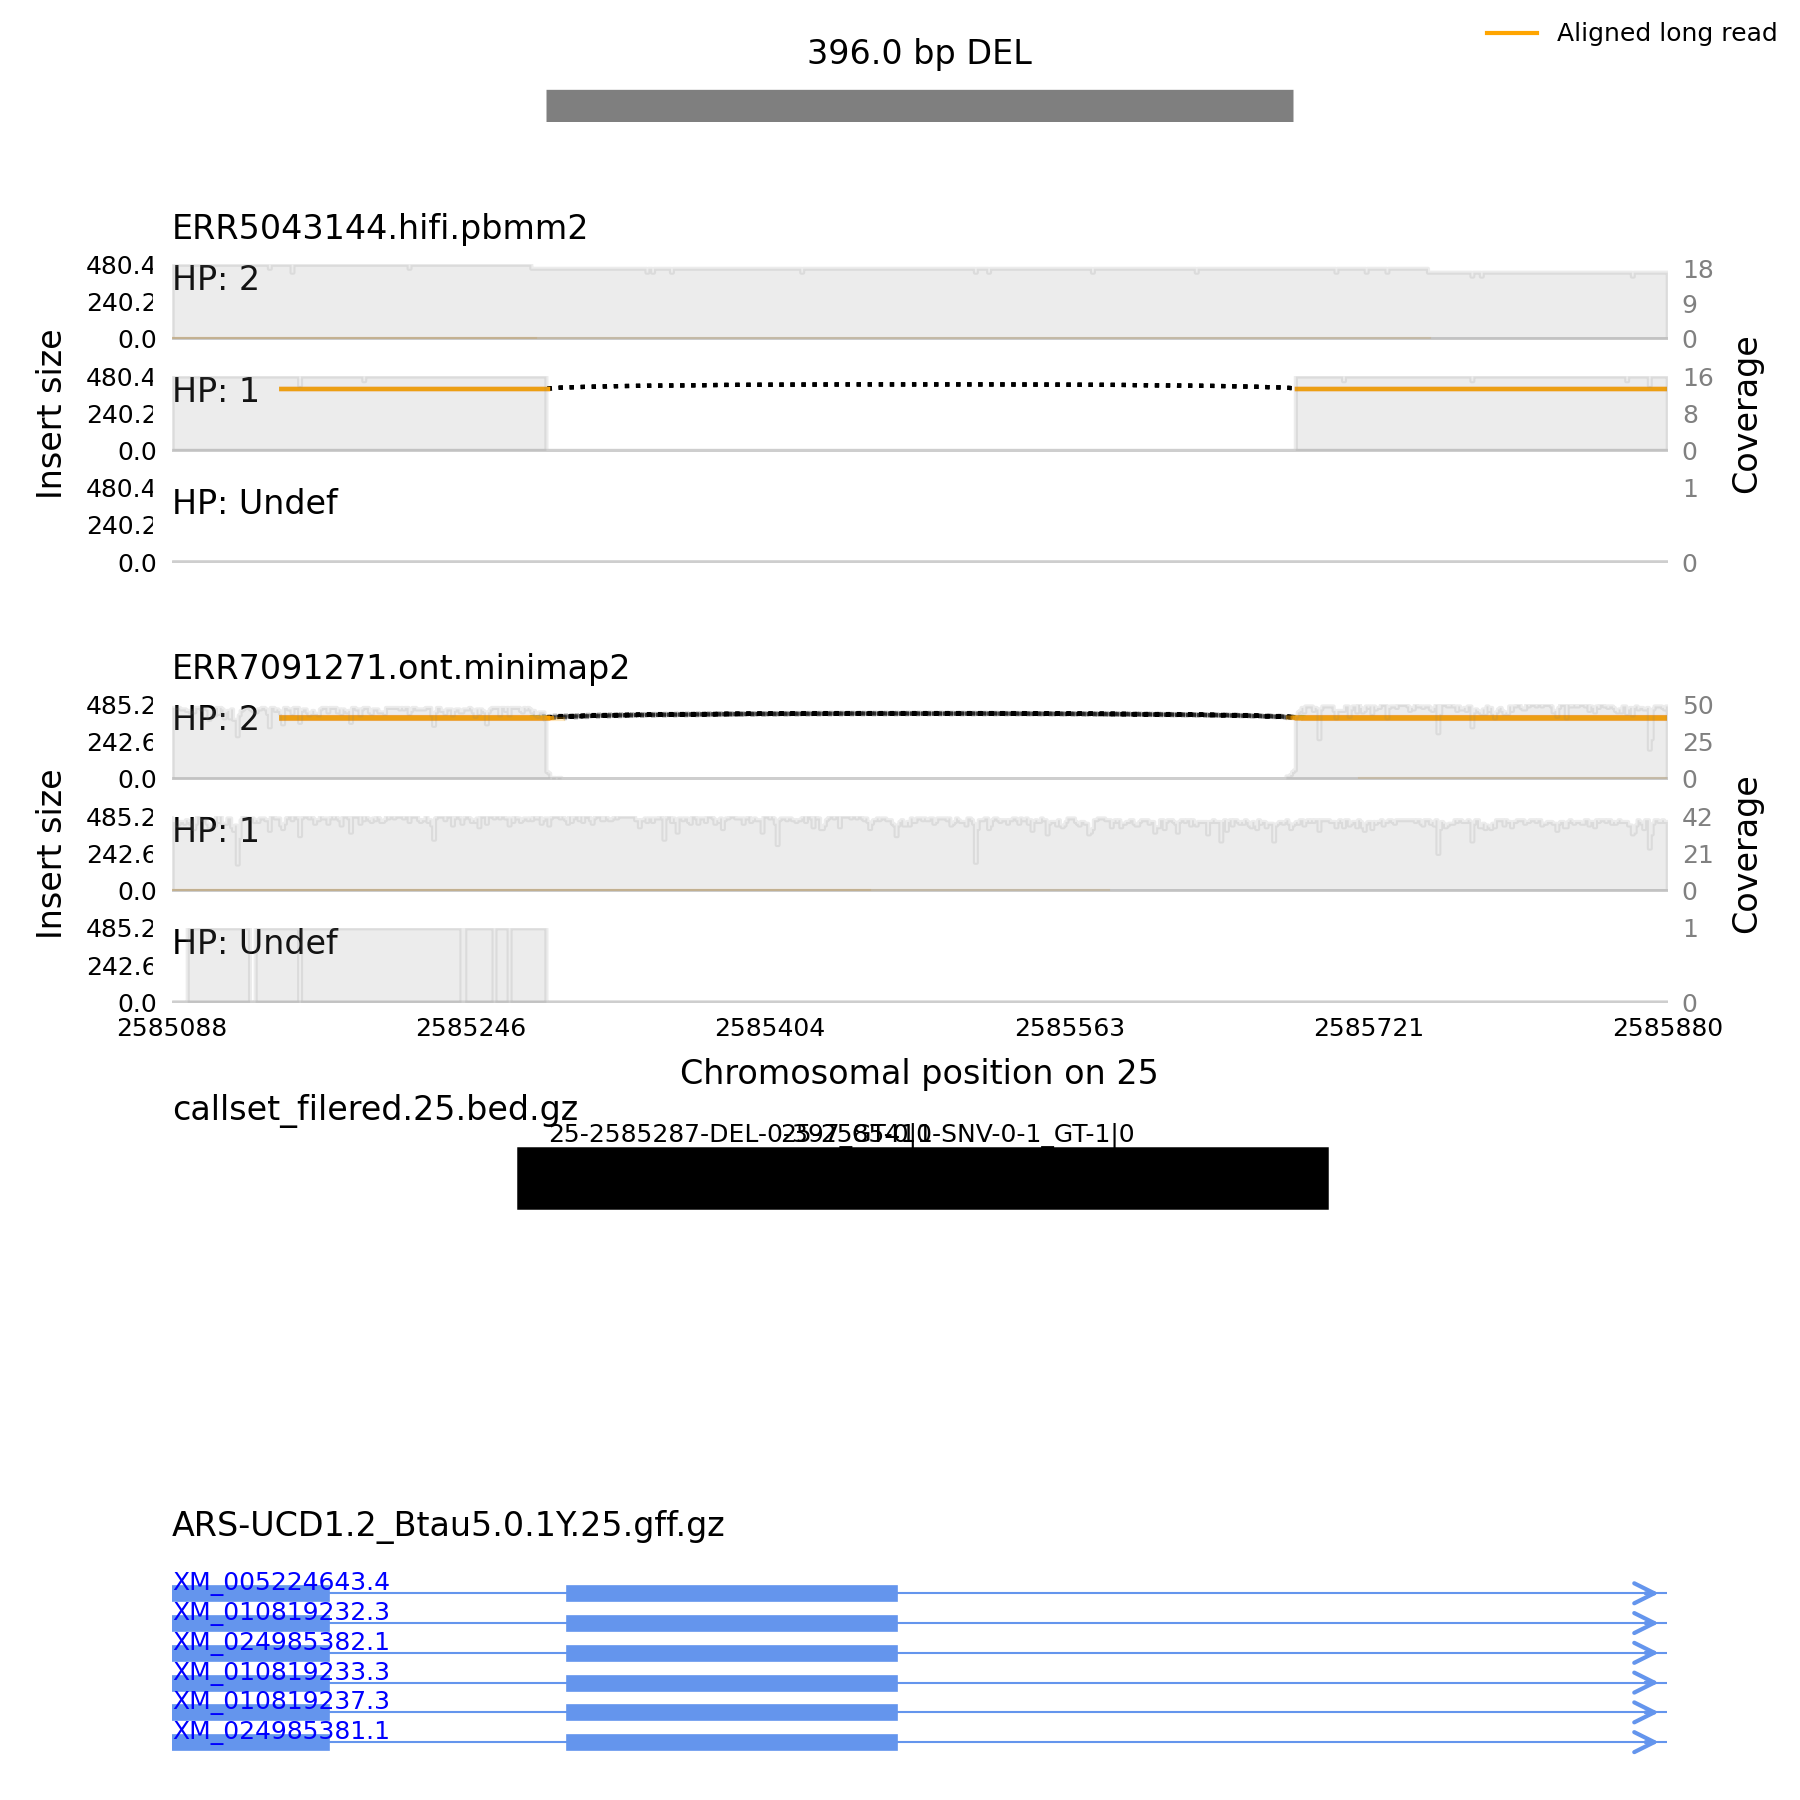

In [19]:
Image(filename='results/samplot/DEL_25_2585286_2585682.png')

## Population Frequency
The Great Genotyper estimate the genotypes for the found variants in 464 cattle samples. We used bcftools to calculate some metrics using the genotypes. Variants at [path] are tagged by the following metadata. 
| Metadata      | Description |
| -- |:-----------:|
| AC | Allele count in genotypes|
| AC_Het | Allele counts in homozygous genotypes|
| AC_Hom | Allele counts in heterozygous genotypes|
| AC_Hemi | Allele counts in hemizygous genotypes|
| AF | Allele frequency |
| MAF | Minor Allele frequency |
| NS | Number of samples with data   |
| AN | Total number of alleles in called genotypes |
| HWE | Hardy-Weinberg equilibrium |
| ExcHet | Test excess heterozygosity; 1=good, 0=bad |


Bcftools is very helpful in filtering vcf files using the variants metadata. For example, We can query the novel varaints using the following command

In [26]:
%%bash
bcftools view  -Q 0.001 < final.vcf.bgz > novel.vcf 
grep -vP "^#" novel.vcf |head -n 4

25	8521	cuteSV-25-8521-DEL-0-12	CCCAGCAACTACG	C	.	PASS	UK=30;MA=0;AF=0;AK=0,30;ID=cuteSV-25-8521-DEL-0-12;NS=428;AN=856;MAF=0;AC=0;AC_Het=0;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=1;CSQ=-|upstream_gene_variant|MODIFIER|5S_rRNA|ENSBTAG00000048872|Transcript|ENSBTAT00000076247|rRNA|||||||||||935|1||RFAM||	GT	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	

# Hail
Although bcftools is very helpful and fast but it is hard to do complex tasks with it. Here we are suggesting using Hail to be able mine the population genotyping results and get meaningful results. Hail is a python library for genomic data expoloration. It creates a matrix table for vcf files which is very similar to R dataframes.

So let's do some coding by intializing Hail engine

In [36]:
import hail as hl
hl.init()
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()

Loading BokehJS ...

Now we are going to load the vcf and samples information to create Hail Matrix table

In [38]:
ref="/home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.fa"
index="/home/mshokrof/workshop_12Jan_2023_data/ARS-UCD1.2_Btau5.0.1Y.25.fa.fai"
vcf="final.vcf.bgz"
samplesInfo="samples.csv"
hlRef=hl.ReferenceGenome.from_fasta_file("ARSUCD",ref,index)

mt = hl.import_vcf(vcf,reference_genome=hlRef)
table = (hl.import_table('samples.csv', impute=True,delimiter=",")
         .key_by('BioSample'))
mt = mt.annotate_cols(breed = table[mt.s])

2023-01-08 23:08:33.535 Hail: INFO: wrote table with 5652 rows in 1 partition to /tmp/persist_tableekCeBef0NQ
2023-01-08 23:08:33.973 Hail: INFO: Reading table to impute column types
2023-01-08 23:08:34.596 Hail: INFO: Finished type imputation
  Loading field 'BioSample' as type str (imputed)
  Loading field 'CompositeBreed' as type str (imputed)
  Loading field 'Cohort' as type str (imputed)


Lets see how the hail matrix table is organized

In [39]:
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'breed': struct {
        CompositeBreed: str, 
        Cohort: str
    }
----------------------------------------
Row fields:
    'locus': locus<ARSUCD>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AF: array<float64>, 
        UK: int32, 
        AK: array<int32>, 
        MA: int32, 
        ID: array<str>, 
        AN: int32, 
        AC: array<int32>, 
        NS: int32, 
        AC_Hom: array<int32>, 
        AC_Het: array<int32>, 
        AC_Hemi: array<int32>, 
        MAF: float64, 
        HWE: array<float64>, 
        ExcHet: array<float64>, 
        CSQ: array<str>
    }
----------------------------------------
Entry fields:
    'GT': call
    'GQ': int32
    'GL': array<float64>
    'KC': float64
    'PL': array<int32>
----------------------------------------
Column key

In [40]:
mt.rows().select().show(5)

2023-01-08 23:08:41.199 Hail: INFO: scanning VCF for sortedness...
2023-01-08 23:08:43.373 Hail: INFO: Coerced sorted VCF - no additional import work to do


,
locus,alleles
locus<ARSUCD>,array<str>
25:241,"[""C"",""G""]"
25:320,"[""G"",""A""]"
25:343,"[""T"",""A""]"
25:465,"[""G"",""A""]"
25:474,"[""T"",""A""]"


In [41]:
mt.s.show(5)

""
s
str
"""SAMEA19309918"""
"""SAMEA19320418"""
"""SAMEA2821387"""
"""SAMEA32988418"""
"""SAMEA32989168"""


In [44]:
mt.aggregate_cols(hl.agg.counter(mt.breed.Cohort))

{'bosoutgroup': 36, 'indicus': 24, 'taurus': 368}

In [45]:
pprint(mt.aggregate_cols(hl.agg.counter(mt.breed.CompositeBreed)))

{'Angus': 21,
 'Anxi': 1,
 'Arsi': 1,
 'Bagaria': 1,
 'Banteng': 1,
 'Barka': 1,
 'Beefmaster': 2,
 'Bison': 1,
 "Blonded'Aquitaine": 1,
 'Boran': 1,
 'Brahman': 7,
 'Brangus': 1,
 'Braunveih': 2,
 'Braunvieh': 3,
 'BrownSwiss': 11,
 'Butana': 1,
 'Charolais': 4,
 'Chianina': 2,
 'ChineseZebu': 1,
 'Cross-Angus-Chianina': 1,
 'Cross-BelgianBlue-Holstein': 1,
 'Cross-Hereford-Holstein': 2,
 'Cross-Hereford-Limousin': 1,
 'Cross-Holstain-Jersey': 1,
 'Cross-Holstein-Jersey': 31,
 'Cross-Jersey-Holstein': 5,
 'Cross-Limousin-Simmental': 1,
 'Crossbreed': 1,
 'Dianzhong': 1,
 'Fogera': 1,
 'Galloway': 1,
 'Gayal': 1,
 'Gelbvieh': 5,
 'GermanBlackPied': 29,
 'Gir': 2,
 'Guanling': 1,
 'Hereford': 5,
 'Holstein': 81,
 'Horro': 1,
 'IndianZebu': 1,
 'Indicus': 1,
 'Jersey': 31,
 'Jinjiang': 1,
 'Kazakh': 1,
 'Kholmogory': 2,
 'Limonero': 1,
 'Limousin': 1,
 'Lingnan': 2,
 'MaineAnjou': 3,
 'Mongolian': 2,
 'Montbeliarde': 2,
 'Mursi': 1,
 'Muturu': 1,
 'NDama': 1,
 'Ndama': 2,
 'Ogaden': 1,
 

Lets do filter the novel variants again using Hail

In [47]:
mt2 = mt.filter_rows(mt.info.AF[0] < 0.001)
print('Samples: %d  Variants: %d' % (mt.count_cols(), mt.count_rows()))
print('After Filter')
print('Samples: %d  Variants: %d' % (mt2.count_cols(), mt2.count_rows()))


Samples: 428  Variants: 215258
After Filter


Samples: 428  Variants: 601


In [49]:
mt2 = mt.filter_rows(mt.info.AF[0] > 0.1)
eigenvalues, pcs, _ = hl.hwe_normalized_pca(mt2.GT)
mt2 = mt2.annotate_cols(scores = pcs[mt2.s].scores)
p = hl.plot.scatter(mt2.scores[0],
                    mt2.scores[1],
                    label=mt2.breed.Cohort,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

2023-01-08 23:19:13.942 Hail: INFO: hwe_normalize: found 128021 variants after filtering out monomorphic sites.
2023-01-08 23:19:16.654 Hail: INFO: Coerced sorted dataset          (0 + 1) / 1]
2023-01-08 23:19:30.004 Hail: INFO: pca: running PCA with 10 components...) / 1]
2023-01-08 23:33:02.669 Hail: INFO: wrote table with 0 rows in 0 partitions to /tmp/persist_tableYGR9h80ior
    Total size: 36.99 KiB
    * Rows: 0.00 B
    * Globals: 36.99 KiB
    * Smallest partition: N/A
    * Largest partition:  N/A


AttributeError: MatrixTable instance has no field, method, or property 'pheno'
    Hint: use 'describe()' to show the names of all data fields.

In [73]:
mt.rows().describe()


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<ARSUCD> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AF: array<float64>, 
        UK: int32, 
        AK: array<int32>, 
        MA: int32, 
        ID: array<str>, 
        AN: int32, 
        AC: array<int32>, 
        NS: int32, 
        AC_Hom: array<int32>, 
        AC_Het: array<int32>, 
        AC_Hemi: array<int32>, 
        MAF: float64, 
        HWE: array<float64>, 
        ExcHet: array<float64>, 
        CSQ: array<str>
    } 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------
